In [1]:
from strace_miner.miner import Miner
from strace_miner.preprocessor.preprocessor import Preprocessor
from strace_miner.preprocessor.strace_line_reader import StraceLineReader

In [3]:
#%%writefile ../strace_miner/miner/io_miner_v1.py

import os
import pm4py 
import pandas as pd
#from .miner import Miner
#from ..preprocessor.preprocessor import Preprocessor
#from ..preprocessor.strace_line_reader import StraceLineReader

class IOMinerV1(Miner):
    def __init__(self,st_log_paths,io_calls):
        super().__init__(st_log_paths)
        self.io_calls = io_calls
        self.dfg = None
        self.dfg_im = None
        self.dfg_fm = None
        self.slr = StraceLineReader()
    
    def preprocess(self,reuse=False):
         for st_path in self.st_log_paths: 
              st = Preprocessor(st_path,self.io_calls,self.slr,'IO')
              case_id = os.path.basename(st_path).split('.st')[0]
              if not reuse:
                st.prepare_csv_log()
            
              self.st_logs[case_id] = st

    def prepare_summaries_and_event_log(self):
         df_all = []
         for case_id,st in self.st_logs.items():
              df = st.get_df_from_csv()
              summary, df = st.process(df)
              self.summaries[case_id] = summary
              df['case'] = case_id
              df = pm4py.format_dataframe(df,case_id='case',activity_key='call',timestamp_key='time')
              df_all.append(df)

         self.el = pm4py.convert_to_event_log(pd.concat(df_all,ignore_index=True))


    def prepare_dfg(self):
         self.dfg,self.dfg_im,self.dfg_fm = pm4py.discover_dfg(self.el)

    def view_dfg(self):
         if self.dfg:
              return pm4py.view_dfg(self.dfg,self.dfg_im,self.dfg_fm)

In [4]:
#LOG_FILE = "logs/multi_threaded.st"
LOG_FILE = "logs/mmarrays.st"

In [5]:
io_calls = ['read','write','mmap','openat']
sta = IOMinerV1([LOG_FILE,],io_calls)
sta.preprocess()
sta.prepare_summaries_and_event_log()
sta.prepare_dfg()

CSV log path: logs/mmarrays.csv


/home/vscode/.local/lib/python3.12/site-packages/pm4py/utils.py:538: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


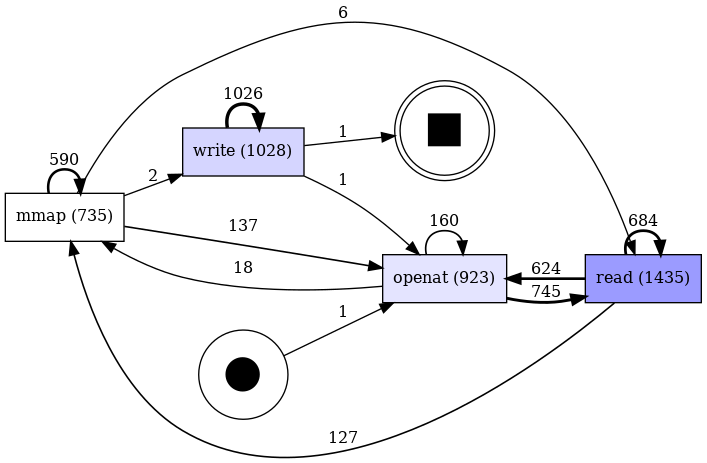

In [6]:
sta.view_dfg()

In [7]:
sta.summaries[list(sta.summaries.keys())[0]]

,call,duration,percent
0,Total,2.968813,100.000000
1,IO time,0.650290,21.904040
2,Remaining time,2.318523,78.095960
3,mmap,0.037607,1.266735
4,openat,0.103154,3.474587
5,read,0.066357,2.235136
6,write,0.443172,14.927582
